# THIS DATASET HAS A PROBLEM
아... 전처리 코드 만들었었는데 실수로 날린듯...

In [1]:
import os
import sys
sys.path.append('../')

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from TFRHelper import *

In [148]:
ds = tfds.load('the300w_lp', split='train')
iterator = ds.as_numpy_iterator()

[[ -46.27452463]
 [ -50.83334036]
 [-311.58166213]] 

[ 0.25402447 -0.86158121 -0.12503039] 24


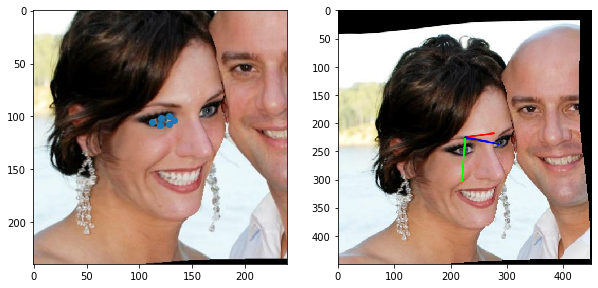

In [187]:
dt = iterator.next()

img = dt['image']
landmarks_3d = dt['landmarks_3d']

img_h, img_w, _  = img.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

all_landmarks = np.multiply(landmarks_3d, [img_h, img_w])

face_bbox = get_face_roi(img, all_landmarks, padding=1)
top, bottom, left, right = face_bbox

w = right - left
h = bottom - top

face = crop_image(img, face_bbox)
required_landmarks = get_required_landmarks(all_landmarks)

landmarks = get_new_landmark(required_landmarks, face_bbox)

face = cv2.resize(face, (240, 240))

resized_landmarks = np.multiply(landmarks, [240 / h, 240 / w])
# to_save_landmark = np.multiply(landmarks, [1 / h, 1 / w])

x, y = np.transpose(resized_landmarks[12:18])
axes[0].scatter(x, y)
axes[0].imshow(face)


# Headpose Estimation
f = img_w
c = (img_w / 2, img_h / 2)

image_points_2d = get2DImagePoints(required_landmarks)
rvec, tvec = getRVec(image_points_2d, f, c)

rmat = cv2.Rodrigues(rvec)[0]

if tvec[-1] < 0:
    rmat[:,1:] = rmat[:,1:] * -1 # note: for some reason, solvePnP fails to find solution on positive z-axis.
hp = rotationMatrixToEulerAngles(rmat)

result_img = img.copy()
pose_position = np.divide(img.shape[:2], 2).astype(int)

points = np.array([[1,0,0], [0,1,0], [0,0,-1]])

points = np.dot(rmat, points.T)
points = points.T

points2D = points[:, :2]
points2D = (points2D * 80 + pose_position).astype(np.int)

cv2.line(result_img, tuple(pose_position), tuple(points2D[0]), (255,0,0), 2, lineType=cv2.LINE_AA)
cv2.line(result_img, tuple(pose_position), tuple(points2D[1]), (0,255,0), 2, lineType=cv2.LINE_AA)
cv2.line(result_img, tuple(pose_position), tuple(points2D[2]), (0,0,255), 2, lineType=cv2.LINE_AA)

axes[1].imshow(result_img)

print(tvec, f'\n\n{hp}', len(required_landmarks))

[[ -46.27452463]
 [ -50.83334036]
 [-311.58166213]] 

[ 0.25402447 -0.86158121 -0.12503039] 24


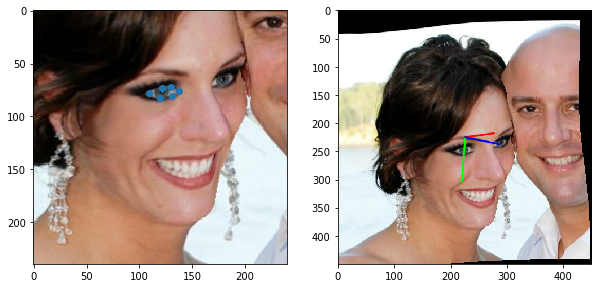

In [188]:
img = dt['image']
landmarks_3d = dt['landmarks_3d']

img_h, img_w, _  = img.shape
all_landmarks = np.multiply(landmarks_3d, [img_h, img_w])

if flip == True:
    img = cv2.flip(img, 1)
    normed = all_landmarks - [img_w/2, img_h/2]
    flip_normed = normed * [-1, 1]
    all_landmarks = flip_normed + [img_w/2, img_h/2]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

face_bbox = get_face_roi(img, all_landmarks, padding=0.5)
top, bottom, left, right = face_bbox

w = right - left
h = bottom - top

face = crop_image(img, face_bbox)
required_landmarks = get_required_landmarks(all_landmarks)

landmarks = get_new_landmark(required_landmarks, face_bbox)

face = cv2.resize(face, (240, 240))

resized_landmarks = np.multiply(landmarks, [240 / h, 240 / w])
# to_save_landmark = np.multiply(landmarks, [1 / h, 1 / w])

x, y = np.transpose(resized_landmarks[12:18])
axes[0].scatter(x, y)
axes[0].imshow(face)


# Headpose Estimation
f = img_w
c = (img_w / 2, img_h / 2)

image_points_2d = get2DImagePoints(required_landmarks)
rvec, tvec = getRVec(image_points_2d, f, c)

rmat = cv2.Rodrigues(rvec)[0]

if tvec[-1] < 0:
    rmat[:,1:] = rmat[:,1:] * -1 # note: for some reason, solvePnP fails to find solution on positive z-axis.
hp = rotationMatrixToEulerAngles(rmat)

result_img = img.copy()
pose_position = np.divide(img.shape[:2], 2).astype(int)

points = np.array([[1,0,0], [0,1,0], [0,0,-1]])

points = np.dot(rmat, points.T)
points = points.T

points2D = points[:, :2]
points2D = (points2D * 80 + pose_position).astype(np.int)

cv2.line(result_img, tuple(pose_position), tuple(points2D[0]), (255,0,0), 2, lineType=cv2.LINE_AA)
cv2.line(result_img, tuple(pose_position), tuple(points2D[1]), (0,255,0), 2, lineType=cv2.LINE_AA)
cv2.line(result_img, tuple(pose_position), tuple(points2D[2]), (0,0,255), 2, lineType=cv2.LINE_AA)

axes[1].imshow(result_img)

print(tvec, f'\n\n{hp}', len(required_landmarks))

# Convert to TFRecord

In [198]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature2(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def get_features(dt):
    img = dt['image']
    landmarks_3d = dt['landmarks_2d']

    img_h, img_w, _  = img.shape

    all_landmarks = np.multiply(landmarks_3d, [img_h, img_w])
    
    flip = False
    if flip == True:
        img = cv2.flip(img, 1)
        normed = all_landmarks - [img_w/2, img_h/2]
        flip_normed = normed * [-1, 1]
        all_landmarks = flip_normed + [img_w/2, img_h/2]

    face_bbox = get_face_roi(img, all_landmarks, padding=1.0)
    top, bottom, left, right = face_bbox

    w = right - left
    h = bottom - top

    face = crop_image(img, face_bbox)
    required_landmarks = get_required_landmarks(all_landmarks)

    landmarks = get_new_landmark(required_landmarks, face_bbox)

    face = cv2.resize(face, (240, 240))

#     resized_landmarks = np.multiply(landmarks, [240 / h, 240 / w])
    to_save_landmark = np.multiply(landmarks, [1 / h, 1 / w])

    # Headpose Estimation
    f = img_w
    c = (img_w / 2, img_h / 2)

    image_points_2d = get2DImagePoints(required_landmarks)
    rvec, tvec = getRVec(image_points_2d, f, c)

    rmat = cv2.Rodrigues(rvec)[0]

    if tvec[-1] < 0:
        rmat[:,1:] = rmat[:,1:] * -1 # note: for some reason, solvePnP fails to find solution on positive z-axis.
    hp = rotationMatrixToEulerAngles(rmat)
    
    encoded_face = tf.io.encode_jpeg(face, quality=100).numpy()
    
    feature = {
        'source': _bytes_feature(bytes('300w_lp', encoding='ascii')),
        'image': _bytes_feature(encoded_face),
        'landmarks': _float_feature(np.reshape(to_save_landmark, (-1)).tolist()),
        'headpose': _float_feature(np.reshape(hp, (-1)).tolist())
    }
    
    return feature


In [199]:
ds = tfds.load('the300w_lp', split='train')
iterator = ds.as_numpy_iterator()

data_path = '/home/gabe/data-archive/facial_landmarks/'
write_path = os.path.join(data_path, '300w_lp_2.tfrecords')

counter = 0

with tf.io.TFRecordWriter(write_path) as writer:
    for dt in iterator:
        feature = get_features(dt)
        
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
        
        if counter % 1000 == 0:
            print(f'{counter}/61255')
        counter = counter + 1

0/61255
1000/61255
2000/61255
3000/61255
4000/61255
5000/61255
6000/61255
7000/61255
8000/61255
9000/61255
10000/61255
11000/61255
12000/61255
13000/61255
14000/61255
15000/61255
16000/61255
17000/61255
18000/61255
19000/61255
20000/61255
21000/61255
22000/61255
23000/61255
24000/61255
25000/61255
26000/61255
27000/61255
28000/61255
29000/61255
30000/61255
31000/61255
32000/61255
33000/61255
34000/61255
35000/61255
36000/61255
37000/61255
38000/61255
39000/61255
40000/61255
41000/61255
42000/61255
43000/61255
44000/61255
45000/61255
46000/61255
47000/61255
48000/61255
49000/61255
50000/61255
51000/61255
52000/61255
53000/61255
54000/61255
55000/61255
56000/61255
57000/61255
58000/61255
59000/61255
60000/61255
61000/61255


# 